## 1. Importing Libraries

In [6]:
import os
import datetime

import scipy.stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean
from tensorflow.keras.utils import Progbar
from tensorflow.keras.datasets import mnist
import uncertainty_wizard as uwiz
import matplotlib.pyplot as plt
from uncertainty_wizard.models.stochastic_utils.layers import UwizBernoulliDropout, UwizGaussianDropout, UwizGaussianNoise
from uncertainty_wizard.models._stochastic._stochastic_mode import StochasticMode
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
import seaborn as sns

## Check GPU

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'Number og GPUs Available: {len(gpus)}')
    for gpu in gpus:
        print('Name:', gpu.name, 'Type:', gpu.device_type)
else:
    print('No GPUs found. Please check your TensorFlow installation and GPU setup')

Number og GPUs Available: 1
Name: /physical_device:GPU:0 Type: GPU


## 2. Load and preprocess MNIST

In [8]:
# Load mnist data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Lenght of training samples
print('Lenght of training samples: ', len(x_train))

# Lenght of test samples
print('\nLenght of test samples: ', len(x_test))

# Shape 
print('\nShape: ', x_train[0].shape)
print('\n-----------------------------------------------------------------')

# Preprocess the data
x_train = (x_train.astype('float32') / 255).reshape(x_train.shape[0], 28, 28, 1)
x_test = (x_test.astype('float32') / 255).reshape(x_test.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

#x_train, x_test = [np.expand_dims(x.astype('float32') / 255, -1) for x in [x_train, x_test]]
#y_train, y_test = [tf.keras.utils.to_categorical(y, num_classes=10) for y in [y_train, y_test]]


def create_stochastic_model():
    model = uwiz.models.StochasticSequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(UwizBernoulliDropout(0.5, stochastic_mode=StochasticMode()))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.legacy.Adadelta(),
                  metrics=['accuracy'])
    
    model.summary()

    return model



# plot 4 images as gray scale
#plt.subplot(141)
#plt.imshow(x_train[0])
#plt.subplot(142)
#plt.imshow(x_train[1])
#plt.subplot(143)
#plt.imshow(x_train[2])
#plt.subplot(144)
#plt.imshow(x_train[3])
#plt.show()

Lenght of training samples:  60000

Lenght of test samples:  10000

Shape:  (28, 28)

-----------------------------------------------------------------


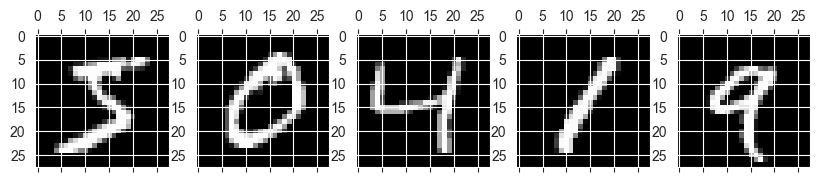

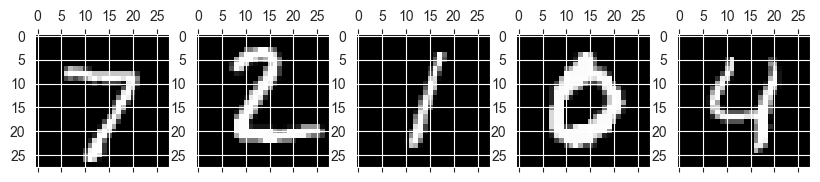

In [9]:
num_images = 5

fig = plt.figure(figsize=(10, 2.5))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i+1)
    ax.matshow(x_train[i].squeeze(), cmap='gray')
    
plt.show()

fig2 = plt.figure(figsize=(10, 2.5))
for i in range(num_images):
    ax = fig2.add_subplot(1, num_images, i+1)
    ax.matshow(x_test[i].squeeze(), cmap='gray')
    
plt.show()

## 3. Train



In [10]:
model = create_stochastic_model()

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3),
                               tf.keras.callbacks.TensorBoard(log_dir='data/logs', histogram_freq=1)])

# Save the model
os.makedirs(os.path.dirname('data/model/'), exist_ok=True)
model.inner.save_weights('data/model/clean_model_weights.h5')
print("\nTraining completed, model weights saved")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 uwiz_bernoulli_dropout_1 (  (None, 12, 12, 64)        0         
 UwizBernoulliDropout)                                           
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

## Visualize Filters 


In [11]:
def visualize_filters_and_layers(model, max_filters=6, layers_to_visualize=None):
    # Access the inner Keras model
    keras_model = model.inner
    
    if layers_to_visualize is None:
        layers_to_visualize = [0]
        
    for layer_index in layers_to_visualize:
        layer = keras_model.layers[layer_index]
        if not isinstance(layer, tf.keras.layers.Conv2D):
            print("The first layer is not a Conv2D layer. Please adjust the layer index.")
            return
    
    # Get the filters from the layer
    filters, biases = layer.get_weights()
    # Normalize the filters
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # Plot the first few filters
    n_filters = min(max_filters, filters.shape[3])
    
    n_columns = 6
    n_rows = n_filters // n_columns if n_filters % n_columns == 0 else n_filters // n_columns +1
    plt.figure(figsize=(20, n_rows * 3))
    plt.suptitle(f'Filters from layer index {layer_index} - {layer.name}')
    
    for i in range(n_filters):
        # Get the filter
        f = filters[:, :, :, i]
        # Plot each channel, modify to f.shape[2] if color
        for j in range(f.shape[2]):
            ax = plt.subplot(n_rows, n_columns, i + 2)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:, :, j], cmap='gray')
    plt.show()

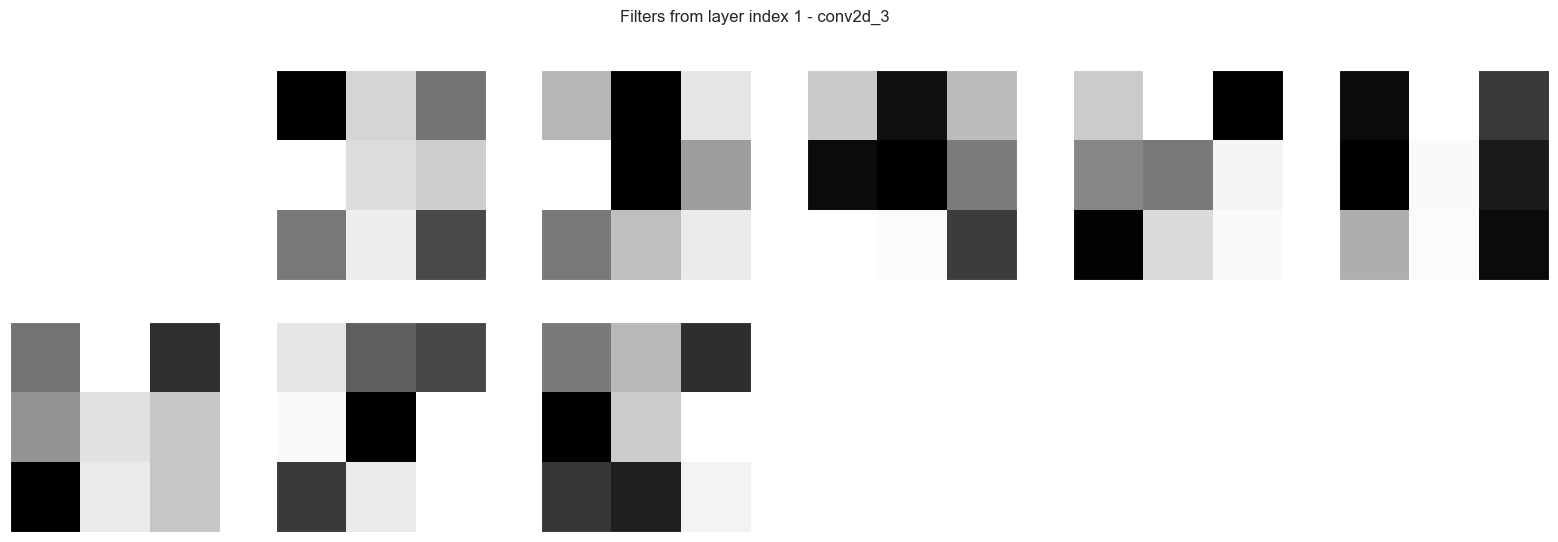

In [12]:
visualize_filters_and_layers(model, max_filters=8, layers_to_visualize=[0, 1])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 uwiz_bernoulli_dropout_1 (  (None, 12, 12, 64)        0         
 UwizBernoulliDropout)                                           
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [14]:
model.inner.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 uwiz_bernoulli_dropout_1 (  (None, 12, 12, 64)        0         
 UwizBernoulliDropout)                                           
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

## Visualize Feature Maps

In [15]:
def visualize_feature_maps(sequential_model, image):
    keras_model = sequential_model.inner
    layer_outputs = [layer.output for layer in keras_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    activation_model = tf.keras.models.Model(inputs=keras_model.input, outputs=layer_outputs)
    # Get feature map activations
    activations = activation_model.predict(image[np.newaxis, ...])
    # Plot the feature maps of the first convolutional layer
    first_layer_activations = activations[0]
    n_features = first_layer_activations.shape[-1]
    size = first_layer_activations.shape[1]
    n_cols = n_features // 16 + min(n_features % 16, 1)
    display_grid = np.zeros((size * n_cols, size * 16))
    for col in range(n_cols):
        for row in range(16):
            if col * 16 + row >= n_features:
                break
            channel_image = first_layer_activations[0, :, :, col * 16 + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title('Feature maps')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()


1/1 [==============================] - 0s 72ms/step


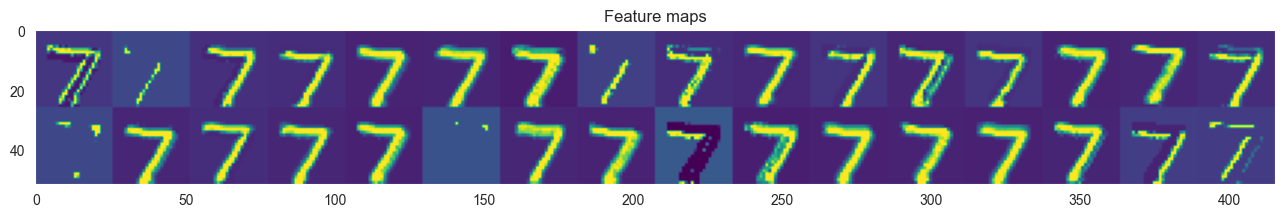

In [16]:
image_to_visualize = x_test[0] 
visualize_feature_maps(model, image_to_visualize)


# Adversarial Training

Adversarial training aims to make the model more robust by incorporating adversarial examples into the training process, thereby learning to generalize better even under adversarial conditions.

Purpose of the adversarial training is to enhance the model's robustness by training it on both clean and adversarially perturbed data. The idea is to make the model learn to generalize well even under adversarial conditions. 

 Process during adversarial training is that we generate adversarial examples using methods like **Projected Gradient Descent (PGD) and then train the model on these examples. Tis is meant to simulate potential attacks and teach the model to recognize and correctly classify both unaltered and altered inputs.

The loss function in the adversarial training setup (CategoricalCrossentropy(from_logits=True)) expects logits (i.e., the model's raw output before the softmax layer) as inputs. If the model ends with a softmax layer, this could mislead the training process.

Solution: Ensure that the model's output is compatible with the loss function's expectations. If the model ends with a softmax activation, we need to set from_logits=False or remove the softmax layer and handle the activation externally.

## Cleverhans tutorial

#### Fast Gradient Sign Method (FGSM)

FGSM is one of the simplest and fastest methods to generate adversarial examples. It perturbs each input by a small amount in the direction of the gradient of the loss with respect to the input.

- `eps` (epsilon) parameter controls the magnitude of the perturbation added to the input images. It defines the step size in the direction of the loss gradient and essentially controls the strength of the attack. Smaller values of `eps` generate adversarial examples that are closer to the orginal inputs, while larger values of `eps` may result in more noticeable perturbations.
- `clip_min`and `clip_max` parameters define the minimum and maximum values that any component of the input tensor can take. They are used to clip the adversarial images to ensure they remain valid images. For example, for images with pixel values in the range [0,1], you would set `clip_min=0` and `clip_max=1`.
- `norm` parameter defines the norm of the perturbations. It's not directly used in FGSM in CleverHans but is relevant for methods that require specifying the norm type for perturbations (like PGD)

#### Projected Gradient Descent (PGD)

PGD is more powerful attack compared to FGSM, iterating multiple times to find more effective adversarial examples within a specified perturbation budget.

**Parameters**:
- `eps`; similar to FGSM, it controls the maximum perturbation that can be added to the input images. It defines the "budget" within which the adversarial examples can be crafted. 
- `eps_iter` controls the step size or the amount of perturbation introduced in each iteration of the attack. Smaller values make the attack more precise but they may require more iterations to converge.
- `nb_iter` specifies the number of iterations the attack will run for. More iterations can lead to more effective adversarial examples but increase computation time.
- `clip_min` and `clip_max` ensures the perturbated images are clipped to maintain valid image values, similar to FGSM.
- `norm`; the norm of the perturbations to use. Common values include `np.inf` (L-infinity norm, withich means changing all pixels with the same magnitude), 1(L1 norm), and 2(L2 norm). The choice of norm affects the nature of the perturbations.


For both FGSM and PGD, setting *eps, eps_iter* and *nb_iter* appropriately is crucial. These need to be chosen considering model's sensitivity and the desired strength and subtlety of the attack.


**References**:
[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)
[Towards Deep Learning Models Resistant to Adversarial Attacks](https://arxiv.org/abs/1706.06083)
[CleverHans Github Repository](https://github.com/cleverhans-lab/cleverhans)
[Adversarial Robustness - Theory and Practice](https://adversarial-ml-tutorial.org/)


In [17]:
# Re-initialize the model for adversarial training
adv_training_model = create_stochastic_model()

optimizer = tf.keras.optimizers.legacy.Adadelta()
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
train_loss = Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

epochs = 1
batch_size = 64
eps = 0.03
for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}/{epochs}')
    
    # Initialize the progress bar
    progbar = Progbar(target=len(x_train) // batch_size, unit_name='batch')
    
    train_loss.reset_state()
    train_accuracy.reset_state()
    
    for batch_index, (x_batch, y_batch) in enumerate(tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)):
        with tf.GradientTape() as tape:
            # Generate adversarial examples 
            x_batch_adv = projected_gradient_descent(adv_training_model.inner, x_batch, eps, 0.01, 40, np.inf)
            
            # Predict on adversarial examples
            adv_pred = adv_training_model.inner(x_batch_adv, training=True)
            loss = loss_object(y_batch, adv_pred)
        
        # Compute gradients and update model weights
        gradients = tape.gradient(loss, adv_training_model.inner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, adv_training_model.inner.trainable_variables))
        
        # Update the metrics
        train_loss.update_state(loss)
        train_accuracy.update_state(y_batch, adv_pred)
        
        # Update the progress bar
        progbar.update(batch_index + 1, values=[("loss", train_loss.result()),
                                                ("accuracy", train_accuracy.result())])

    # Logging the metrics at the end of an epoch
    print(f'Epoch {epoch + 1}, Loss: {train_loss.result().numpy()}, Accuracy: {train_accuracy.result().numpy()}')
        
os.makedirs(os.path.dirname('data/model/'), exist_ok=True)
adv_training_model.inner.save_weights('data/model/adv_trained_model_weights.h5')
print("\nAdversarial training completed, model weights saved")
        

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 uwiz_bernoulli_dropout_2 (  (None, 12, 12, 64)        0         
 UwizBernoulliDropout)                                           
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

## 4. Plot Traning & Validation Accuracy and Loss 

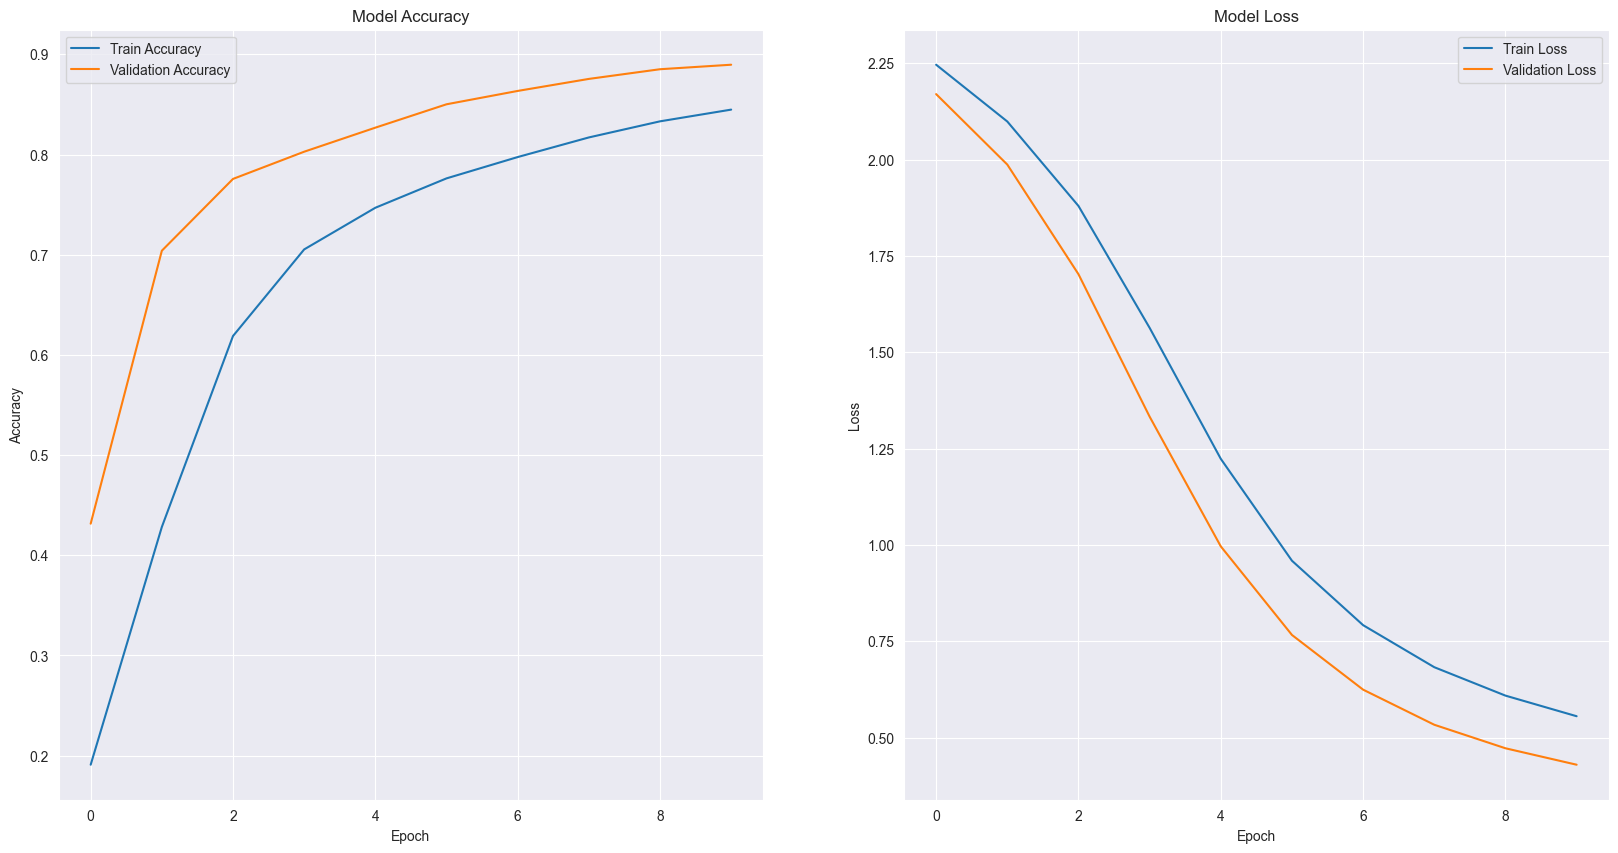

In [18]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 5. Evaluate Model

In [19]:
# Load the saved model weights
model.inner.load_weights('data/model/clean_model_weights.h5')
print("Model weights loaded from disk")

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
#print('\nTest accuracy', test_acc)
#print('\nTest loss', test_loss)
print(f'\nTest Loss: {test_loss*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%')

# Making predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the mean squared error
mse = tf.reduce_mean(tf.square(y_pred - y_test))
print(f'\nMSE: {mse:.3f}')


num_samples = 25
predictions = model.predict(x_test[:num_samples])
predicted_labels = np.argmax(predictions, axis=1)

Model weights loaded from disk
313/313 - 2s - loss: 0.4794 - accuracy: 0.8747 - 2s/epoch - 8ms/step

Test Loss: 47.94%, Test Accuracy: 87.47%
313/313 [==============================] - 1s 3ms/step

MSE: 0.021
1/1 [==============================] - 0s 27ms/step


In [20]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 12.53%


In [21]:
_, rmse = model.evaluate(x_train, y_train, verbose=0)
print(f'Test RMSE: {round(rmse, 3)}')

Test RMSE: 0.864


In [22]:
# Confusion Matrix and Classification Report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print("\n")
print(classification_report(y_true, y_pred_classes))

313/313 [==============================] - 1s 3ms/step
[[ 936    0    3    5    1    4   11    1   19    0]
 [   0 1098    9    5    1    4    4    0   14    0]
 [  18    3  870   16   15    0   25   23   60    2]
 [   5    4   25  897    0   22    3   20   25    9]
 [   3    7    4    0  841    0   22    3    6   96]
 [  19   10    7   90   25  647   21    5   54   14]
 [  16   16   15    2   10   21  872    1    5    0]
 [   1   33   23    5   13    0    1  895    9   48]
 [   9   19    8   33    7   35   11   22  817   13]
 [  15   16    8   12   31    6    1   38    8  874]]


              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.91      0.97      0.94      1135
           2       0.90      0.84      0.87      1032
           3       0.84      0.89      0.86      1010
           4       0.89      0.86      0.87       982
           5       0.88      0.73      0.79       892
           6       0.90      0.91

## Adversarial Evaluation

The adversarial evaluation phase is designed to assess how well the model can identify and correctly classify images that have been deliberately perturbated to mislead it. This phase does not directly evaluate the adversarial training but rather tests the model's robustness against adversarial attacks. 

To evaluate the model's performance and robustness after it has been trained, specifically its ability to withstand adversarial attacks. This phase assesses how well the model, whether trained traditionally or with adversarial examples, can handle new, unseen adversarial inputs.

We generate new adversarial examples from the test set (which the model has not seen during training) using attack methods like **Fast Gradient Sign Method (FGSM) and PGD. The model's accuracy and loss metrics are then evaluated based on its predictions for these adversially perturbed images.

Whether the model underwent adversarial training or not, the adversarial evaluation can be performed to test its robustness. The expectation is that models trained with adversarial examples will perform better in this phase than models trained only on clean data.

In [23]:
"""
Generate adversarial examples batch by batch within a loop then trying to evaluate the model on a single batch of adversarial examples against the entire y_test dataset
"""

if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

test_accuracy = SparseCategoricalAccuracy()

# Evaluate on clean examples
for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
    predictions = model.predict(x_batch)
    test_accuracy.update_state(y_batch, predictions)
    
accuracy_clean = test_accuracy.result().numpy() * 100
print(f'\nTest accuracy on clean examples: {accuracy_clean:.2f}%')

# Adversarial evaluation settings
eps = 0.3
test_accuracy_fgsm = SparseCategoricalAccuracy()
test_accuracy_pgd = SparseCategoricalAccuracy()

# Evaluate on adversarial examples (FGSM and PGD)
for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
    # FGSM examples
    x_adv_fgsm = fast_gradient_method(model.inner, x_batch, eps, np.inf)
    predictions_fgsm = model.predict(x_adv_fgsm)
    test_accuracy_fgsm.update_state(y_batch, predictions_fgsm)
    
        
    # PGD examples
    x_adv_pdg = projected_gradient_descent(model.inner, x_batch, eps, 0.01, 40, np.inf)
    predictions_pdg = model.predict(x_adv_pdg)
    test_accuracy_pgd.update_state(y_batch, predictions_pdg)
    
accuracy_fgsm = test_accuracy_fgsm.result().numpy() * 100
accuracy_pdg = test_accuracy_pgd.result().numpy() * 100


print(f'\nTest accuracy on FGSM adversarial examples: {accuracy_fgsm:.2f}%')
print(f'Test accuracy on PDG adversarial examples: {accuracy_pdg:.2f}%')

accuracies = [accuracy_clean, accuracy_fgsm, accuracy_pdg]

1/1 [==============================] - 0s 11ms/step

Test accuracy on clean examples: 87.47%
1/1 [==============================] - 0s 10ms/step

Test accuracy on FGSM adversarial examples: 6.31%
Test accuracy on PDG adversarial examples: 6.52%


In [24]:
"""
Creating adversarial examples for the entire test dataset and then evaluating the model on these examples
"""

if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)
    

model.inner.load_weights('data/model/clean_model_weights.h5')

# Generate adversarial examples for the entire test set
x_test_adv_fgsm = fast_gradient_method(model.inner, x_test, eps, np.inf, clip_min=0., clip_max=1.)
x_test_adv_pgd = projected_gradient_descent(model.inner, x_test, eps, eps_iter=0.01, nb_iter=40, norm=np.inf, clip_min=0., clip_max=1.)

# Evaluate model on the entire set of FGSM adversarial examples
loss_fgsm, accuracy_fgsm_entire = model.evaluate(x_test_adv_fgsm, tf.keras.utils.to_categorical(y_test), verbose=2)
print(f'Accuracy on FGSM adversarial examples: {accuracy_fgsm_entire*100:.2f}%')

# Evaluate the model on the entire set of PGD adversarial examples
loss_pgd, accuracy_pgd_entire = model.evaluate(x_test_adv_pgd, tf.keras.utils.to_categorical(y_test), verbose=2)
print(f'Accuracy on PGD adversarial examples: {accuracy_pgd_entire*100:.2f}%')


313/313 - 3s - loss: 3.9795 - accuracy: 0.0644 - 3s/epoch - 9ms/step
Accuracy on FGSM adversarial examples: 6.44%
313/313 - 3s - loss: 4.3201 - accuracy: 0.0631 - 3s/epoch - 8ms/step
Accuracy on PGD adversarial examples: 6.31%


## 7. Plot Predictions, Confusion Matrix, Adversarial examples and Comparison between

#### Classification Report 

Classification report shows a summary of the performance of a classification model on a test dataset. It shows several important metrics for each class (in our case, the digits 0 through 9), as well as overall averages:
- **Precision** measures the accuracy of positive predictions for each class. It's defined as the number of true positive predictions divided by the total number og positive predictions (true positives plus false positives), e.g., for digit 0, a precision of 0.98 means that 98% of the model's prediction for digit 0 were correct.
- **Recall** (also known as sensitivity) measures the ability if the model to find all the relevant cases within a dataset. It's defined as the number of true positive predictions divided by the total number of actual positives (true positives plus false negatives). E.g., for digit 0, a recall of 0.99 means the model correctly identified 99% if all actual 0s in the dataset.
- **F1-Score** is a measure of a model's accuracy that combines precision and recall into a single metric by taking their harmonic mean. It's useful when we need to balance precision and recall. An F1-score of 0.99 for digit 0 indicates a very good balance between precision and recall for this class.
- **Support** is the number of actual occurrences of the class in the specified dataset.

- **Accuracy** measures the proportion of all predictions that the model got right, across all classes.
- **Macro avg** refers to the average metrics (precision, recall, f1-score), calculated independently for each class and then taking the average. This treats all classes equally, regardless of their support in the dataset.
- **Weighted avg** calculated the average of the metrics, taking into account the support of each class. This means that the contribution of each class to the average is weighted by its prevalence.

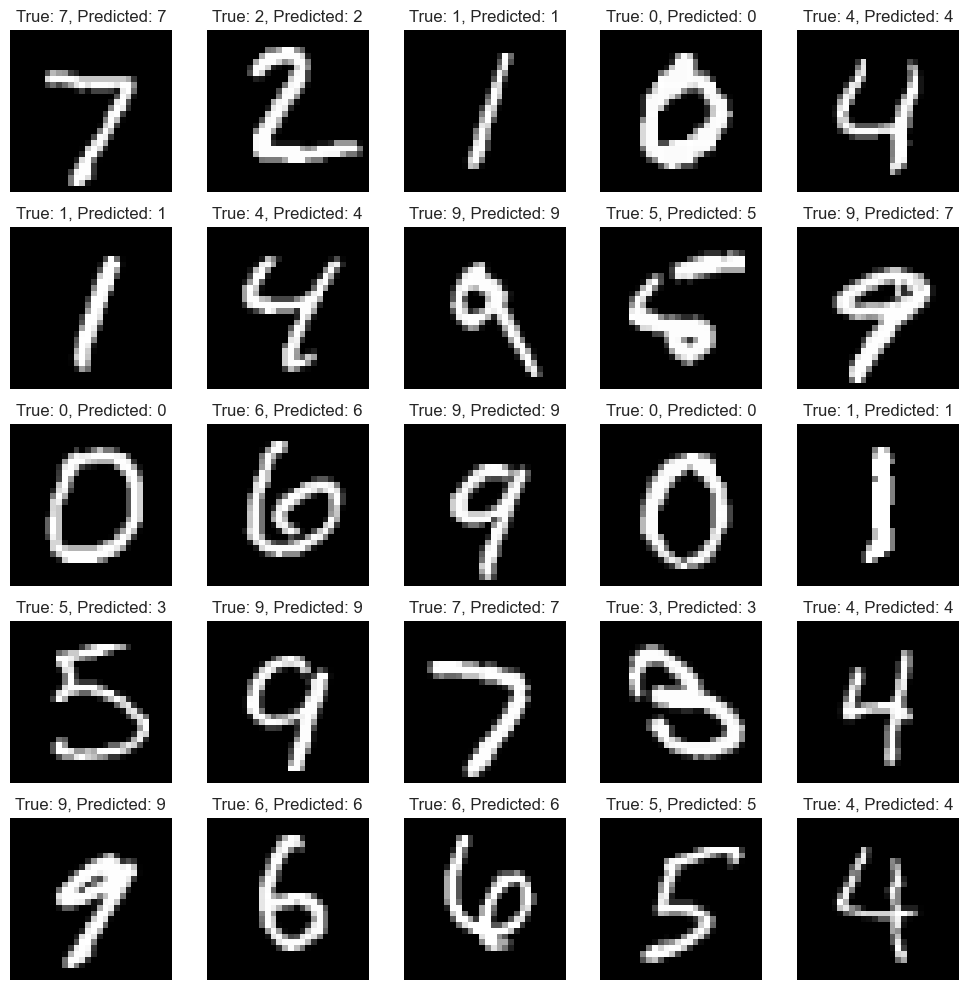

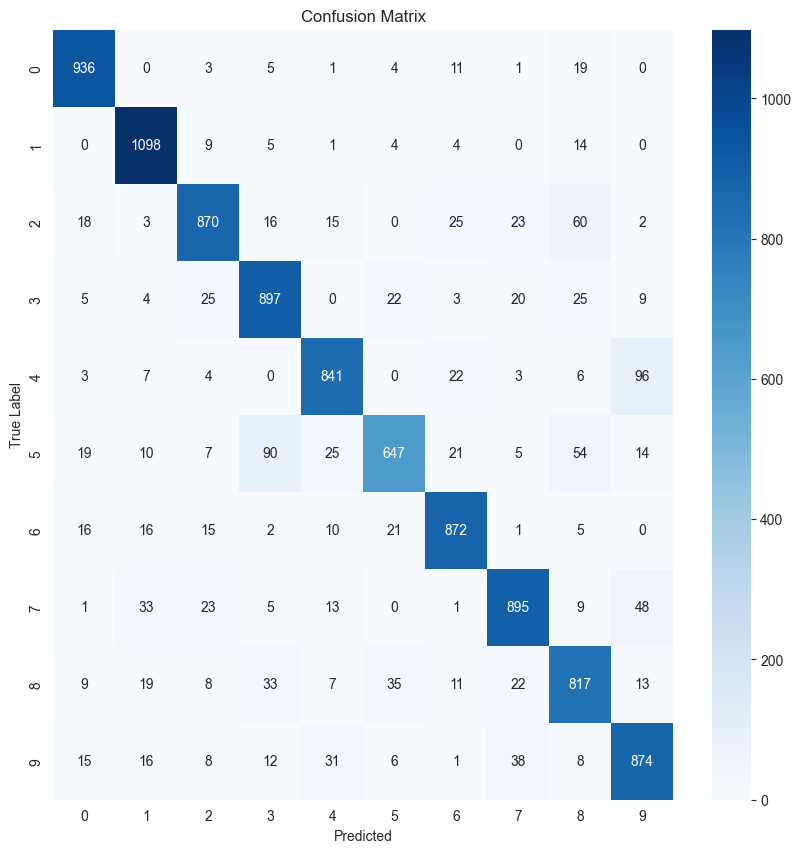

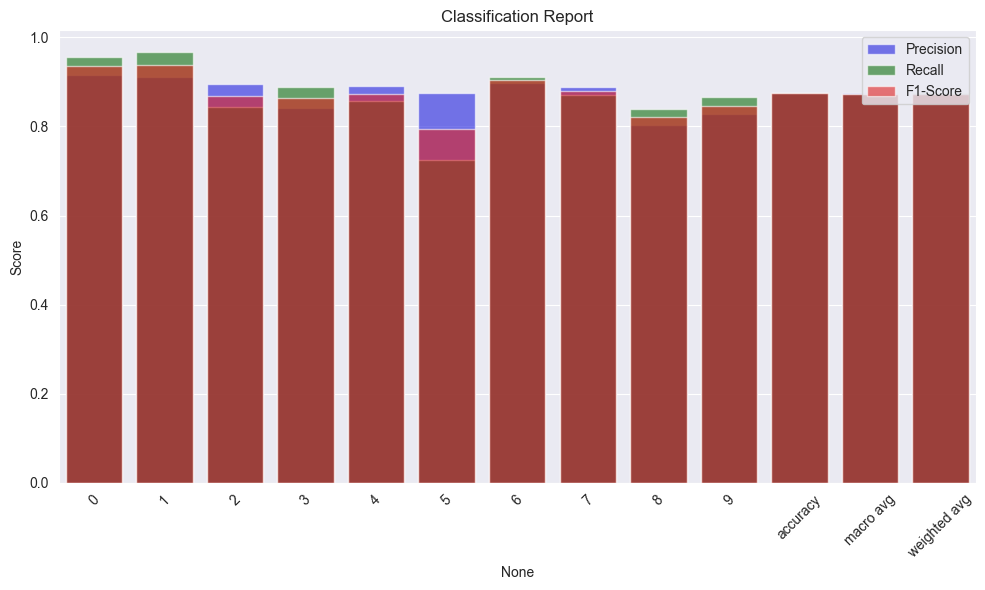

1/1 [==============================] - 0s 11ms/step


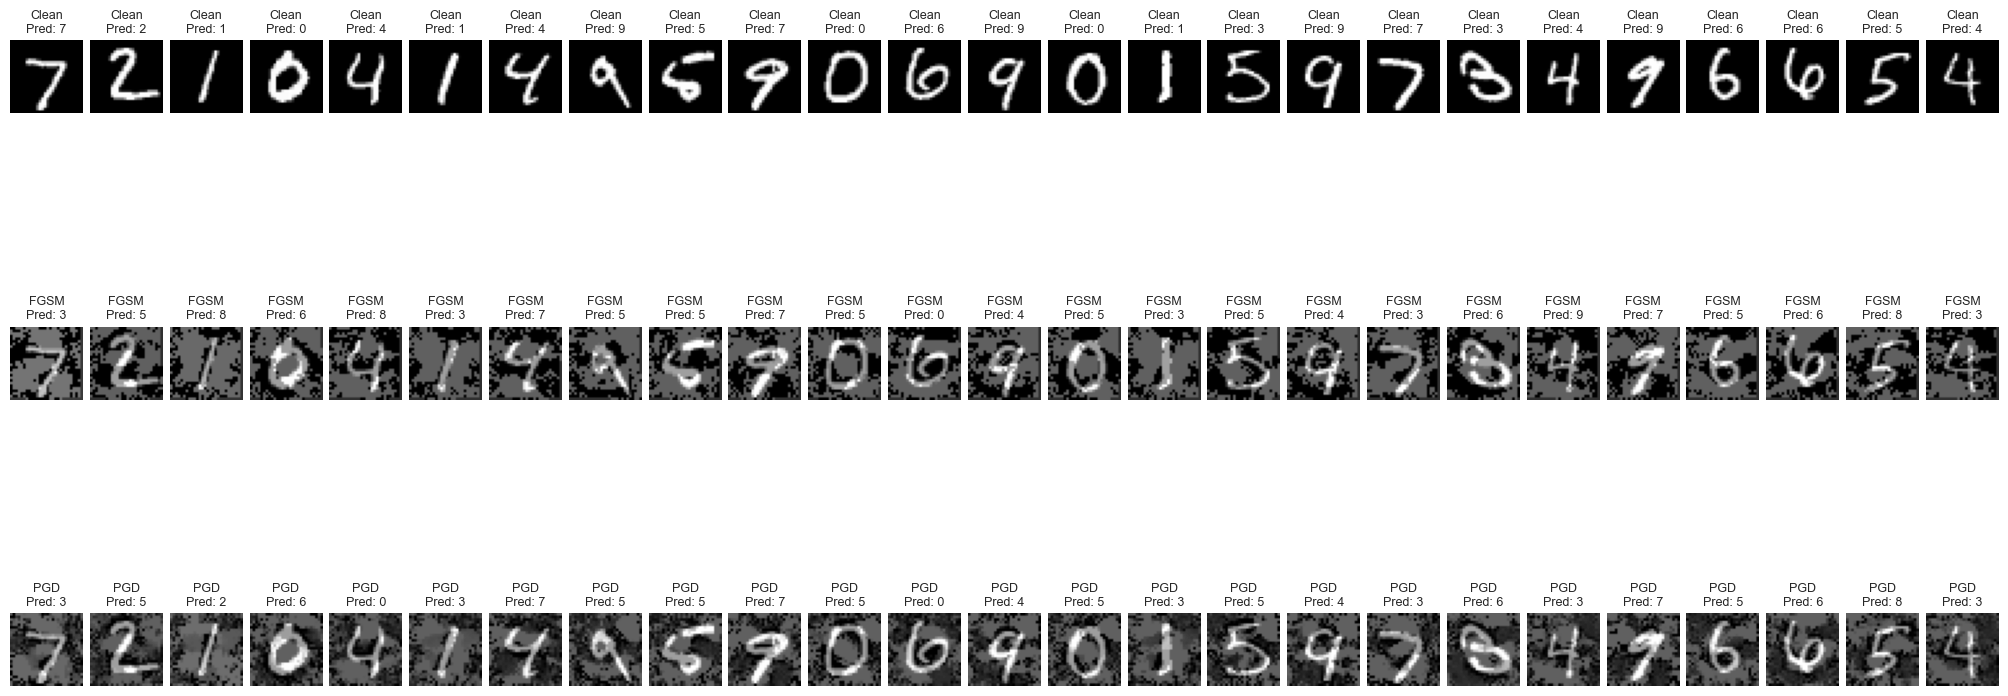

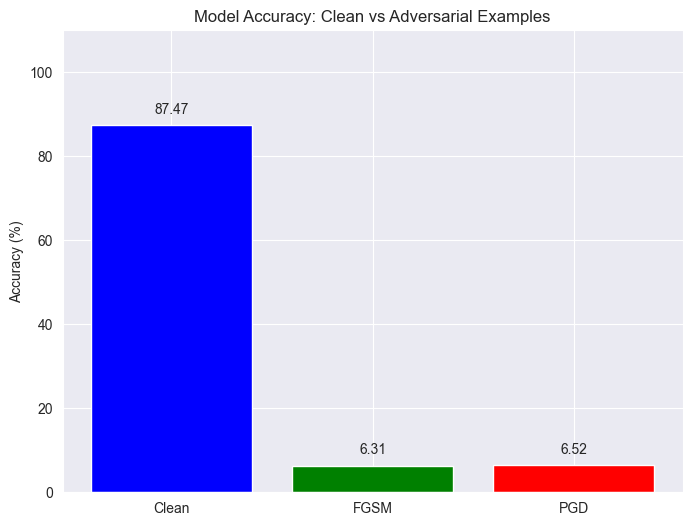

In [25]:
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_true[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()


# Classification Report
y_pred_labels = np.argmax(y_pred, axis=1)

if y_true.ndim > 1:
    y_true_labels = np.argmax(y_true, axis=1)
else:
    y_true_labels = y_true
# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

# Convert the report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Remove the 'support' 
df_report = df_report.drop(columns=['support'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_report, x=df_report.index, y='precision', label='Precision', color='b', alpha=0.6)
sns.barplot(data=df_report, x=df_report.index, y='recall', label='Recall', color='g', alpha=0.6)
sns.barplot(data=df_report, x=df_report.index, y='f1-score', label='F1-Score', color='r', alpha=0.6)

plt.xticks(rotation=45)
plt.title('Classification Report')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Clean and Adversarial examples

#x_adv_fgsm = fast_gradient_method(model.inner, x_test[:num_samples], eps, np.inf)
#predictions_clean = np.argmax(model.predict(x_test[:num_samples]), axis=1)
#predictions_adv = np.argmax(model.predict(x_adv_fgsm), axis=1)

# Generate FGSM adversarial examples
x_adv_fgsm = fast_gradient_method(model.inner, x_test[:num_samples], eps, np.inf)
predictions_fgsm = np.argmax(model.predict(x_adv_fgsm), axis=1)

# Generate PGD adversarial examples
x_adv_pgd = projected_gradient_descent(model.inner, x_test[:num_samples], eps, 0.01, 40, np.inf)
predictions_pgd = np.argmax(model.predict(x_adv_pgd), axis=1)

plt.figure(figsize=(20, 10))
#plt.figure(figsize=(2 * num_samples, 6))

for i in range(num_samples):
    # Plot clean images
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(x_test[i], cmap='gray')  # If x_test is not already in 28x28, reshape is needed
        plt.title(f'Clean\nPred: {np.argmax(model.predict(x_test[i:i+1]), axis=1)[0]}', fontsize=9)
        plt.axis('off')

        # Plot FGSM adversarial images
        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(x_adv_fgsm[i], cmap='gray')
        plt.title(f'FGSM\nPred: {predictions_fgsm[i]}', fontsize=9)
        plt.axis('off')

        # Plot PGD adversarial images
        plt.subplot(3, num_samples, 2 * num_samples + i + 1)
        plt.imshow(x_adv_pgd[i], cmap='gray')
        plt.title(f'PGD\nPred: {predictions_pgd[i]}', fontsize=9)
        plt.axis('off')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'pred_clean_vs_adv_{timestamp}.png'
plot_dir = './data/plots//evaluate'
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, filename))

plt.show()


# Compare
plt.figure(figsize=(8, 6))
bar_positions = np.arange(len(accuracies))
plt.bar(bar_positions, accuracies, color=['blue', 'green', 'red'])
plt.xticks(bar_positions, labels=['Clean', 'FGSM', 'PGD'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy: Clean vs Adversarial Examples')
plt.ylim(0, 110)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.2f}', ha='center', va='bottom')
    
plt.show()

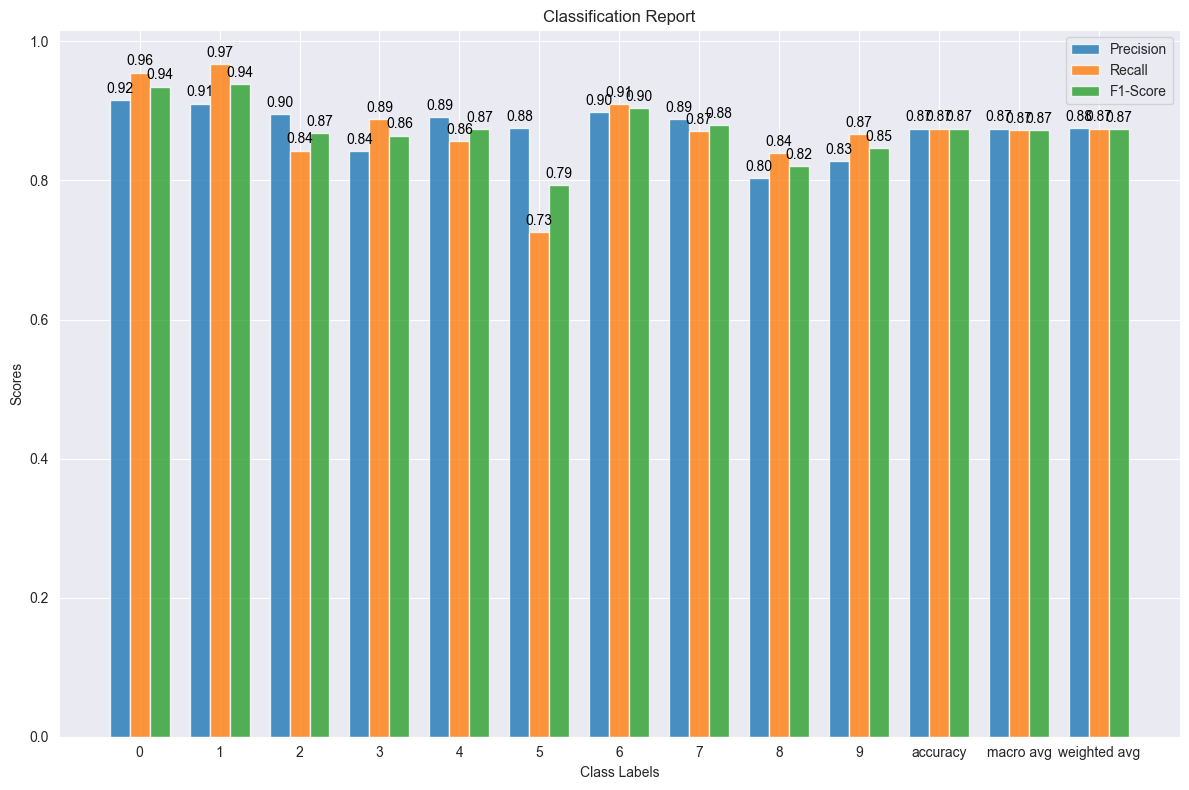

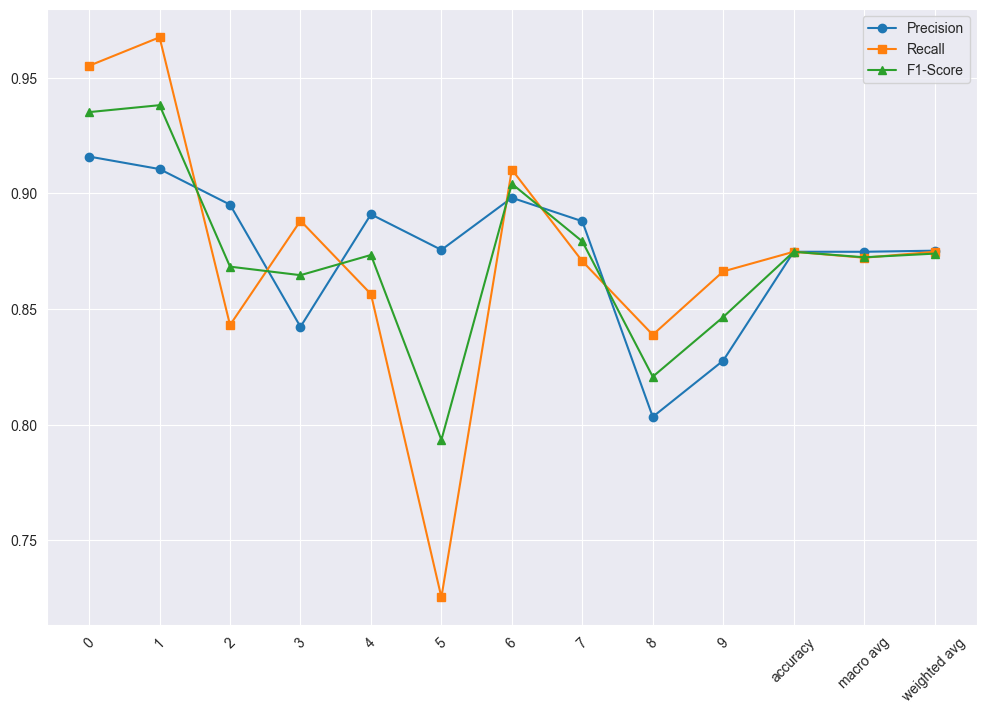

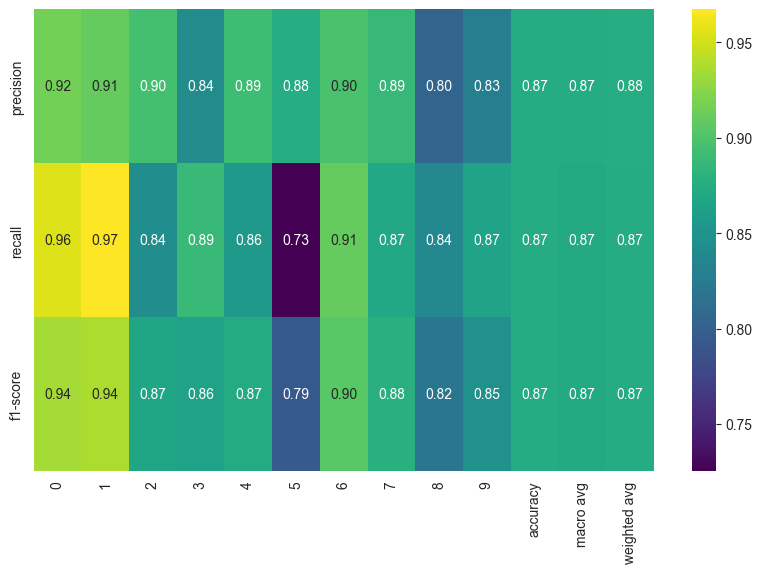

In [26]:
# Classification Report
y_pred_labels = np.argmax(y_pred, axis=1)

if y_true.ndim > 1:
    y_true_labels = np.argmax(y_true, axis=1)
else:
    y_true_labels = y_true
# Generate classification report
report = classification_report(y_true, y_pred_labels, output_dict=True)

# Convert the report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Remove the 'support' column if it exists
df_report.drop(columns='support', errors='ignore', inplace=True)

fig, ax = plt.subplots(figsize=(12, 8))

# Get the x locations for the groups
indices = np.arange(len(df_report.index))

bar_width = 0.25

precision = ax.bar(indices, df_report['precision'], bar_width, label='Precision', alpha=0.8)
recall = ax.bar(indices + bar_width, df_report['recall'], bar_width, label='Recall', alpha=0.8)
f1_score = ax.bar(indices + 2 * bar_width, df_report['f1-score'], bar_width, label='F1-Score', alpha=0.8)

# Add the text annotation on the bars
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{0:.2f}'.format(bar.get_height()),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')

add_value_labels(ax, precision)
add_value_labels(ax, recall)
add_value_labels(ax, f1_score)

ax.set_xlabel('Class Labels')
ax.set_ylabel('Scores')
ax.set_title('Classification Report')
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(df_report.index)
ax.legend()
plt.tight_layout()
plt.show()

# Line plot with markers
plt.figure(figsize=(12, 8))
plt.plot(df_report.index, df_report['precision'], marker='o', label='Precision')
plt.plot(df_report.index, df_report['recall'], marker='s', label='Recall')
plt.plot(df_report.index, df_report['f1-score'], marker='^', label='F1-Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_report[['precision', 'recall', 'f1-score']].T, annot=True, fmt='.2f', cmap='viridis')
plt.show()

## 8. Analyze the Uncertainty

In the context of neural networks, uncertainty quantification is crucial for assessing the confidence of model predictions. There are two primary types of uncertainty:

1. **Aleatoric Uncertainty**: This type of uncertainty is inherent in the data. It arises from noise or variability in the data and can be captured directly from the data itself.
2. **Epistemic Uncertainty**: This uncertainty is due to the model's lack of knowledge. It can be reduced with more data or better models and is often where dropout-based methods come into play.

#### Uncertainty Wizard Quantifiers

1. **Prediction Confidence Score (PCS):**
    
    - PCS is a measure of the model's confidence in its predictions. For classification tasks, this often translates to how high the softmax output is for the predicted class. A higher PCS indicates higher confidence in the prediction.
2. **Mean Softmax:**
    
    - Mean Softmax is typically used in stochastic models where multiple predictions are made for the same input (as in Monte Carlo Dropout). It refers to the average of the softmax outputs across all predictions for a given input. It can be interpreted as an averaged confidence level across multiple runs.


In [27]:
# Load the saved model weights 
model.inner.load_weights('data/model/clean_model_weights.h5')
print("Model weights loaded from disk")

# Perform uncertainty quantification
quantifiers = ['pcs', 'mean_softmax']
results = model.predict_quantified(x_test,
                                    quantifier=quantifiers,
                                    batch_size=64,
                                    sample_size=32,
                                    verbose=1)


Model weights loaded from disk
157/157 [==============================] - 1s 3ms/step


From Uncertainty-Wizard github repo [Uncertainty Wizard Examples](https://github.com/testingautomated-usi/uncertainty-wizard/blob/main/examples/MnistStochasticSequential.ipynb):

- `sample_size=32`: means it will use 32 predictions to compute the uncertainty estimates.
- `results[0][0]` : point-prediction using the 'pcs' quantifier, which are the class predictions made by a single forward pass of the non-randomized network.
- `results[0][1]` : prediction confidence socres for each of the point-predictions.
- `result[1][0]`  : predictions made using the 'mean_softmax' quantifier, which are the class predictions based on the average of 32 forward pass samples using the randomized DNN (i.e., with dropout applied during inference).
- `results[1][1]` : confidence for the 'mean_softmax' predictions, which is the average softmax value of the class with the highest average softmax value across the 32 samples.


## 9. Plots for Uncertainty Analysis

**Prediction Confidence Score (PCS)** is complement of "uncertainty" scores. High PCS values imply high confidence, and therefore low uncertainty. There would be found in `results[0][1]`.

**Mean Softmax Scores** can also be considered as confidence scores, where higher values indicate higher confidence. Thus, the uncertainty could be considered the inverse of these scores as well. These scores are found in `results[1][1]`. 

Uncertain region will be at the lower end of the score spectrum. With inverse of confidence scores we could interpret lower PCS values as higher uncertainty. To do this we simply subtract PCS values from 1. 

To calculate the uncertainty threshold based on confidence scores, we look for a high percentile in the confidence score distribution to find where the model's confidence starts to decline significantly. The corresponding low percentile in that distribution will be uncertainty threshold.

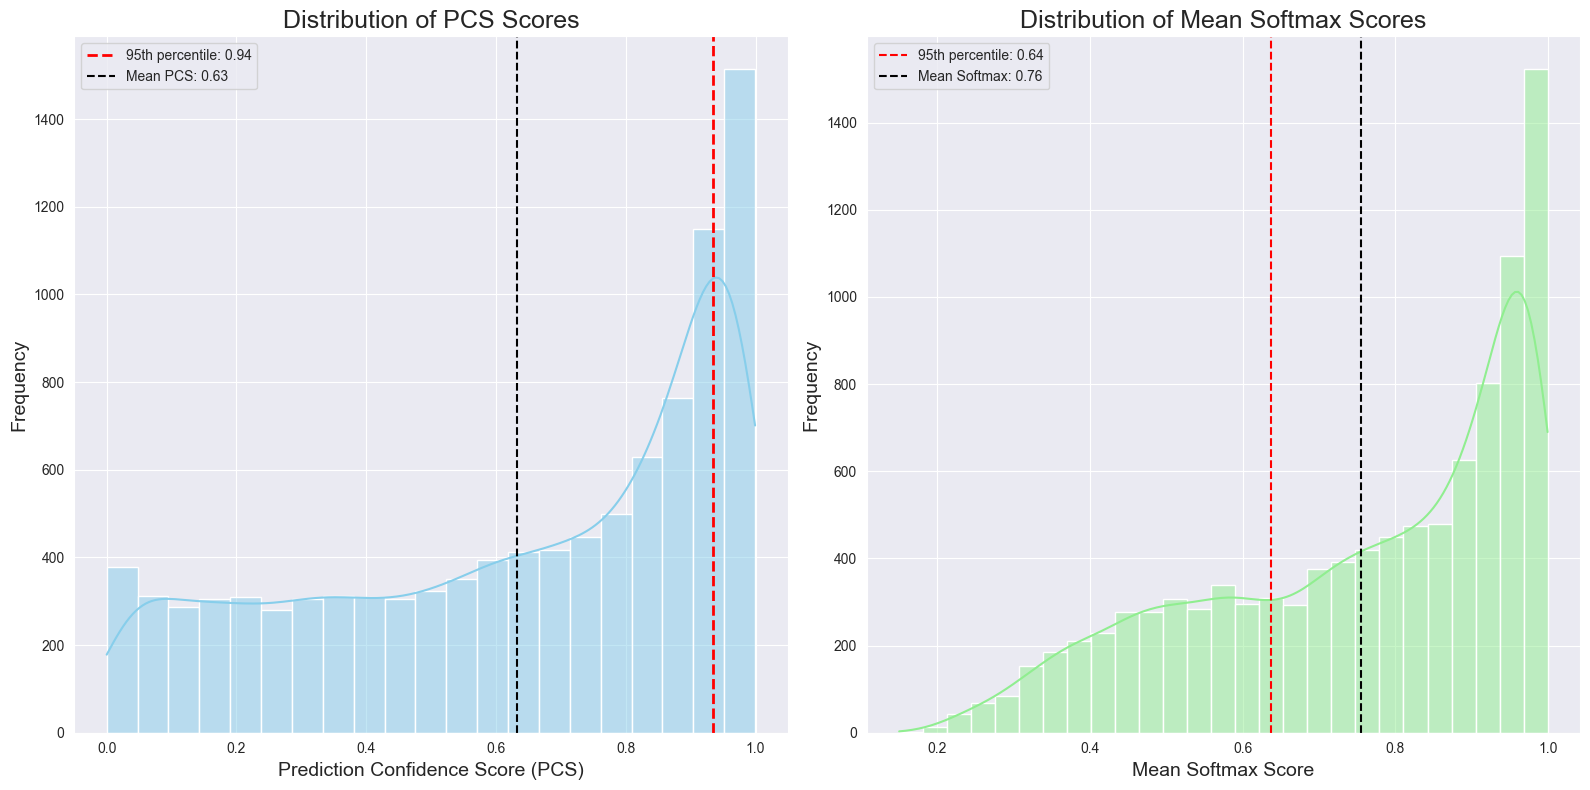

In [122]:
pcs_scores = results[0][1]
mean_softmax_scores = results[1][1]

pcs_inverse = 1 - pcs_scores
uncertainty_threshold_pcs = np.percentile(pcs_inverse, 95)
mean_softmax_inverse = 1 - mean_softmax_scores
uncertainty_threshold_mean_softmax = np.percentile(mean_softmax_inverse, 95)


plt.figure(figsize=(16, 8))
# First subplot for PCS scores
plt.subplot(1, 2, 1)
sns.histplot(pcs_scores, bins='auto', kde=True, color='skyblue')
plt.axvline(uncertainty_threshold_pcs, color='r', linestyle='dashed', linewidth=2, label=f'95th percentile: {uncertainty_threshold_pcs:.2f}')
plt.axvline(np.mean(pcs_scores), color='k', linestyle='dashed', label=f'Mean PCS: {np.mean(pcs_scores):.2f}')
plt.xlabel('Prediction Confidence Score (PCS)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of PCS Scores', fontsize=18)
plt.legend()

# Second subplot for Mean Softmax scores
plt.subplot(1, 2, 2)
sns.histplot(mean_softmax_scores, bins='auto', kde=True, color='lightgreen')
plt.axvline(uncertainty_threshold_mean_softmax, color='r', linestyle='dashed', label=f'95th percentile: {uncertainty_threshold_mean_softmax:.2f}')
plt.axvline(np.mean(mean_softmax_scores), color='k', linestyle='dashed', label=f'Mean Softmax: {np.mean(mean_softmax_scores):.2f}')
plt.xlabel('Mean Softmax Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Mean Softmax Scores', fontsize=18)
plt.legend()

plt.tight_layout()
#plt.savefig('path', dpi=300)
plt.show()


The histogram shows the frequency of the PCS and Mean Softmax Scores. We can see that as the scores increase, the frequency also increases, especially towards scores of 1, which indicates very high confidence in the predictions.

In [127]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribution of PCS Scores", "Distribution of Mean Softmax Scores"))

# First subplot for PCS scores
fig.add_trace(go.Histogram(x=pcs_scores, name='PCS Scores', marker_color='skyblue'), row=1, col=1)
fig.add_trace(go.Scatter(x=[uncertainty_threshold_pcs, uncertainty_threshold_pcs], y=[0, max(np.histogram(pcs_scores, bins='auto')[0])], mode="lines", name=f'95th percentile: {uncertainty_threshold_pcs:.2f}', line=dict(color='red', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=[np.mean(pcs_scores), np.mean(pcs_scores)], y=[0, max(np.histogram(pcs_scores, bins='auto')[0])], mode="lines", name=f'Mean PCS: {np.mean(pcs_scores):.2f}', line=dict(color='black', dash='dash')), row=1, col=1)

# Second subplot for Mean Softmax scores
fig.add_trace(go.Histogram(x=mean_softmax_scores, name='Mean Softmax Scores', marker_color='lightgreen'), row=1, col=2)
fig.add_trace(go.Scatter(x=[uncertainty_threshold_mean_softmax, 
                            uncertainty_threshold_mean_softmax], 
                            y=[0, max(np.histogram(mean_softmax_scores, bins='auto')[0])],
                         mode="lines", name=f'95th percentile: {uncertainty_threshold_mean_softmax:.2f}', 
                         line=dict(color='red', dash='dash')), row=1, col=2)
fig.add_trace(go.Scatter(x=[np.mean(mean_softmax_scores), np.mean(mean_softmax_scores)], 
                         y=[0, max(np.histogram(mean_softmax_scores, bins='auto')[0])], 
                         mode="lines", name=f'Mean Softmax: {np.mean(mean_softmax_scores):.2f}', 
                         line=dict(color='black', dash='dash')), row=1, col=2)

fig.update_layout(title_text='Interactive Distribution Plots', xaxis_title_text='Score', 
                  yaxis_title_text='Frequency', bargap=0.2, height=600, width=1200)
fig.show()

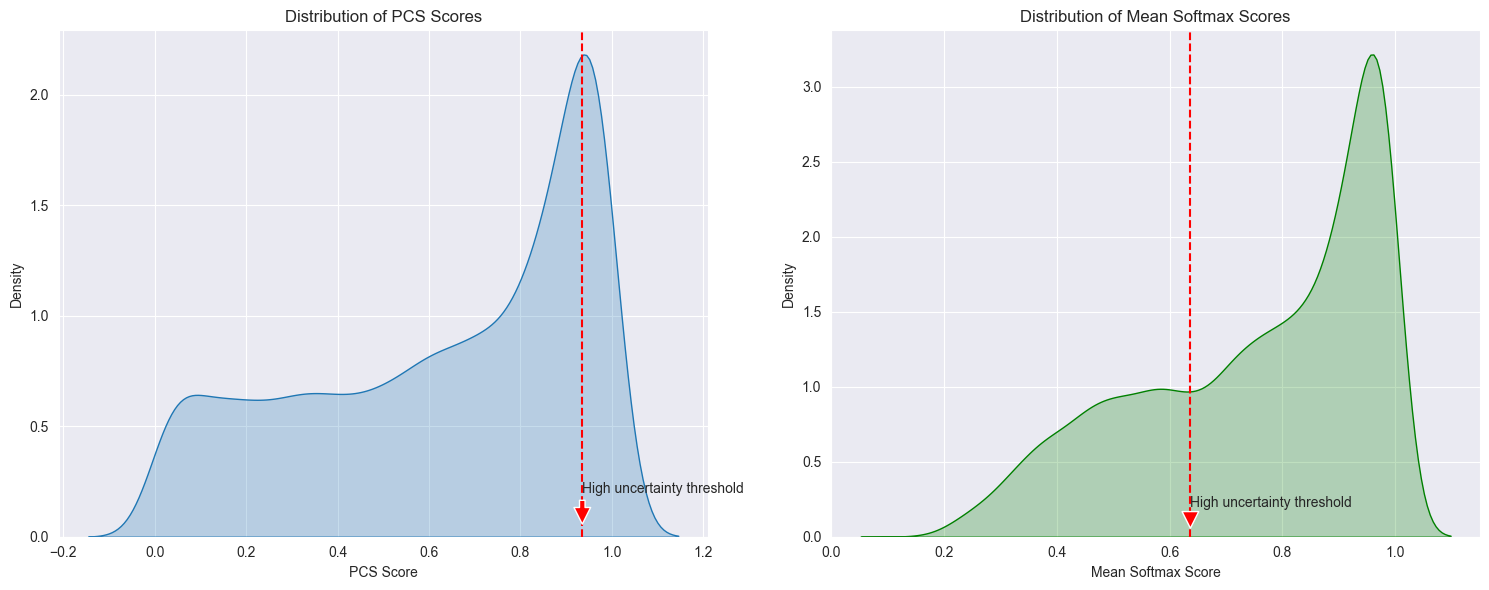

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# KDE plot for PCS Scores
sns.kdeplot(pcs_scores, ax=axes[0], fill=True)
axes[0].axvline(uncertainty_threshold_pcs, color='r', linestyle='--')
axes[0].annotate('High uncertainty threshold', xy=(uncertainty_threshold_pcs, 0.05), xytext=(uncertainty_threshold_pcs, 0.2),
             arrowprops=dict(facecolor='red', shrink=0.05))
axes[0].set_title('Distribution of PCS Scores')
axes[0].set_xlabel('PCS Score')
axes[0].set_ylabel('Density')

# KDE plot for Mean Softmax Scores
sns.kdeplot(mean_softmax_scores, ax=axes[1], fill=True, color='g')
axes[1].axvline(uncertainty_threshold_mean_softmax, color='r', linestyle='--')
axes[1].annotate('High uncertainty threshold', xy=(uncertainty_threshold_mean_softmax, 0.05), xytext=(uncertainty_threshold_mean_softmax, 0.2),
             arrowprops=dict(facecolor='red', shrink=0.05))
axes[1].set_title('Distribution of Mean Softmax Scores')
axes[1].set_xlabel('Mean Softmax Score')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Quantify Uncertainty

### 1. Entropy (Predictive Uncertainty)
Entropy quantifies the uncertainty in the model's predictions, used commonly for classification tasks. It's defined as:


$H(y|x) = -\sum_{c} p(y=c|x) \log(p(y=c|x))$

Where:
- $H(y|x)$ is the entropy of the predictive distribution given input $x$
- $p(y=c|x)$ is the predicted probability of class $c$ given input $x$
- The summation is over all classes $c$

### 2. Predictive Confidence

Predictive confidence can be represented as the maximum predicted probability for any class, indicating the model's confidence in its most likely prediction:

\[\text{Predictive Confidence} = max_{c} p(y=c|x)\]

Predictive Confidence = $max_{c} p(y=c|x)$

Where:
$max_{c}$ finds the maximum probability across all classes $c$

### 3. Mutual Information (Quantifying Epistemic Uncertainty)

Mutual information between the model predictions and the underlying model parameters can quantify epistemic uncertainty, highlighting the model's knowledge about its predictions:

$I(y; \theta | x, D) = H(y | x, D) - \mathbb{E}_{p(\theta | D)}[H(y | x, \theta)]$

Where:
- $I(y; \theta | x, D)$ is the mutual information between predictions $y$ and parameters $\theta$ given input $x$ and data $D$
- $H(y | x, D)$ is the entropy of the predictive distribution.
- $\mathbb{E}_{p(\theta | D)}[H(y | x, \theta)]$ is the expected entropy of the predictive distribution, averaged over the posterior distribution of the parameters $p(\theta|D)$.

In [30]:
"""  
Quantify the uncertainty for both clean and adversarial examples using the `predict_quantified` method from Uncertainty Wizard  
"""  
  
eps = 0.3

# Generate adversarial examples for quantification  
x_test_adv = fast_gradient_method(model.inner, x_test, eps, np.inf)  
  
# If x_test_adv is a TensorFlow tensor, convert it to numpy array  
if isinstance(x_test_adv, tf.Tensor):  
    x_test_adv = x_test_adv.numpy()  
  
# Quantify uncertainty for clean examples  
clean_uncertainty = model.predict_quantified(x_test,  
                                             quantifier='predictive_entropy',
                                             batch_size=64,
                                             sample_size=32,  
                                             verbose=1)  
  
# Quantify uncertainty for adversarial examples 
adv_uncertainty = model.predict_quantified(x_test_adv,  
                                           quantifier='predictive_entropy',  
                                           batch_size=64,
                                           sample_size=32,  
                                           verbose=1)

5000/5000 [==============================] - 18s 4ms/step


## Histogram of Uncertainty Distribution

This histogram visualizes the distribution of predictive entropy for two different sets of data: 
- Clean examples 
- Adversarial examples

Predictive entropy is a measure of uncertainty in the predictions of AI model. <u>A higher entropy value suggests higher uncertainty</u>.

Blue bars represents the clean examples and the orange bars represents the adversarial examples. The x-axis is the "Predictive Entropy" and the y-axis is the frequency of each entropy value.

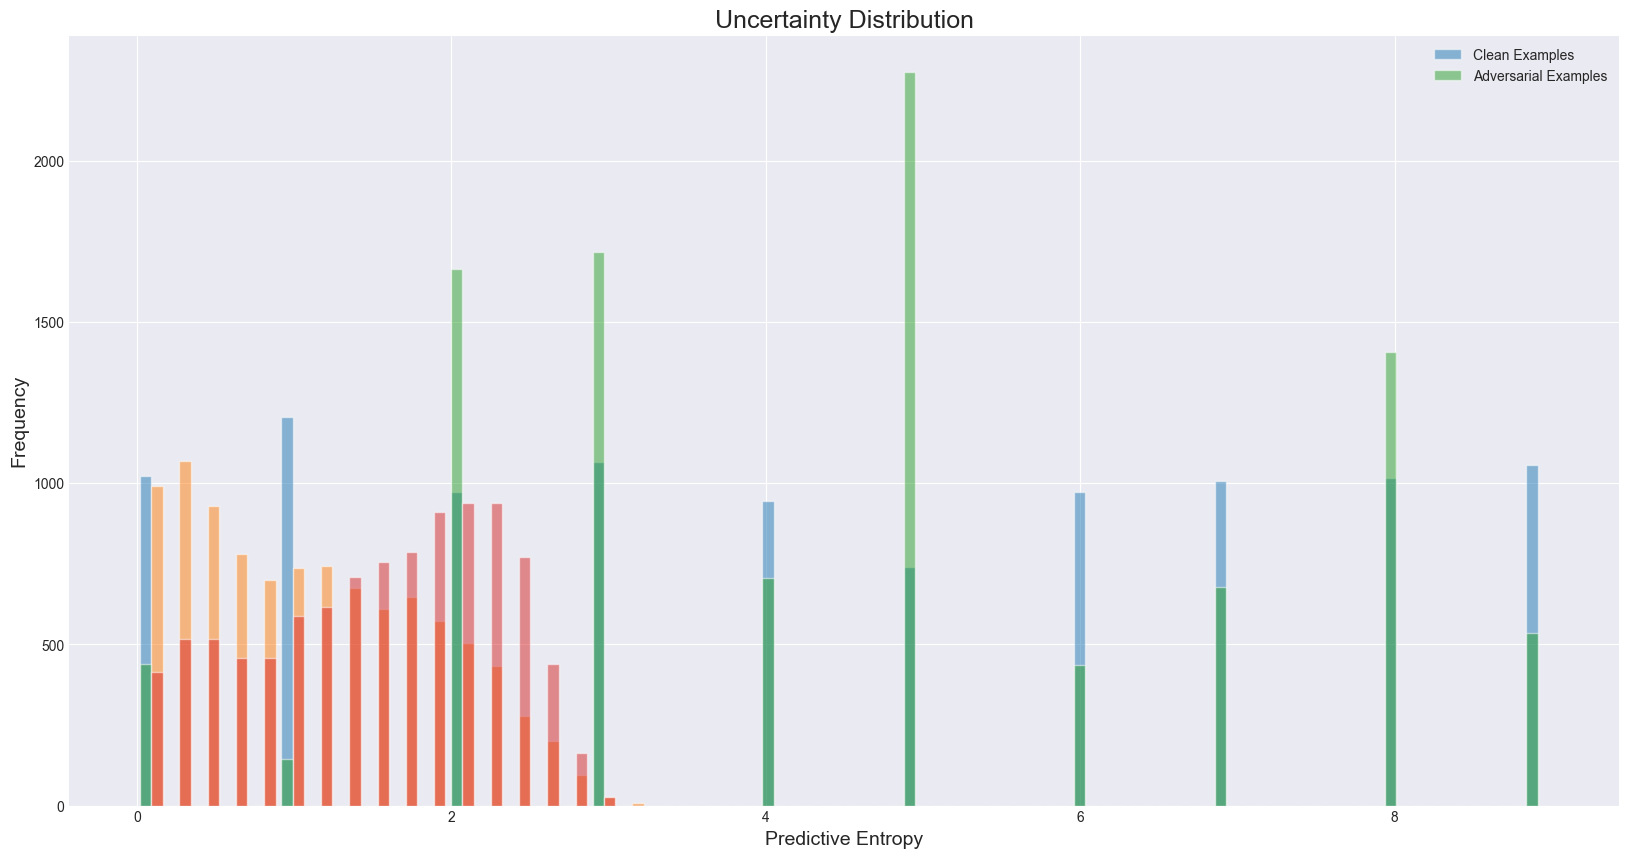

In [136]:
# Histogram for clean examples
plt.figure(figsize=(20, 10))
plt.hist(clean_uncertainty, bins=50, alpha=0.5, label='Clean Examples')
# Histogram for adversarial examples
plt.hist(adv_uncertainty, bins=50, alpha=0.5, label='Adversarial Examples')
plt.xlabel('Predictive Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.title('Uncertainty Distribution', fontsize=18)
plt.show()

## Highlighting Highly Uncertain Inputs

This is used to identify and display inputs for which the model has high uncertainty. It defines a threshold for uncertainty, calculates the mean uncertainties for clean examples, and identifies those inputs where the uncertainty is greater than threshold.

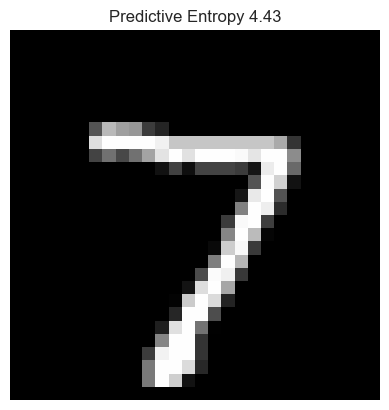

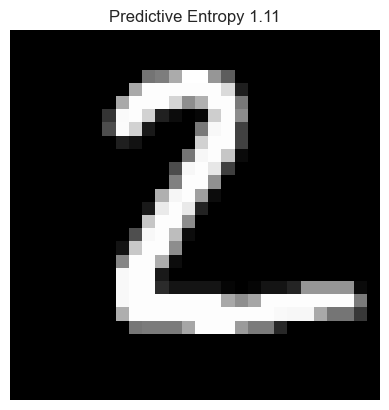

In [32]:
uncertainty_scores_threshold = np.array(uncertainty_scores)

mean_uncertainty = np.mean(uncertainty_scores_threshold)
std_uncertainty = np.std(uncertainty_scores_threshold)
threshold = mean_uncertainty + std_uncertainty

mean_uncertainties = np.mean(clean_uncertainty, axis=1)

# Identify highly uncertain inputs for clean examples
high_uncertainty_indexes = [i for i, uncertainty in enumerate(mean_uncertainties) if uncertainty > threshold]

# Display some of the highly uncertain inputs
for i in high_uncertainty_indexes[:5]: # Display the first 5
    plt.figure()
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f'Predictive Entropy {mean_uncertainties[i]:.2f}')
    plt.axis('off')
    plt.show()

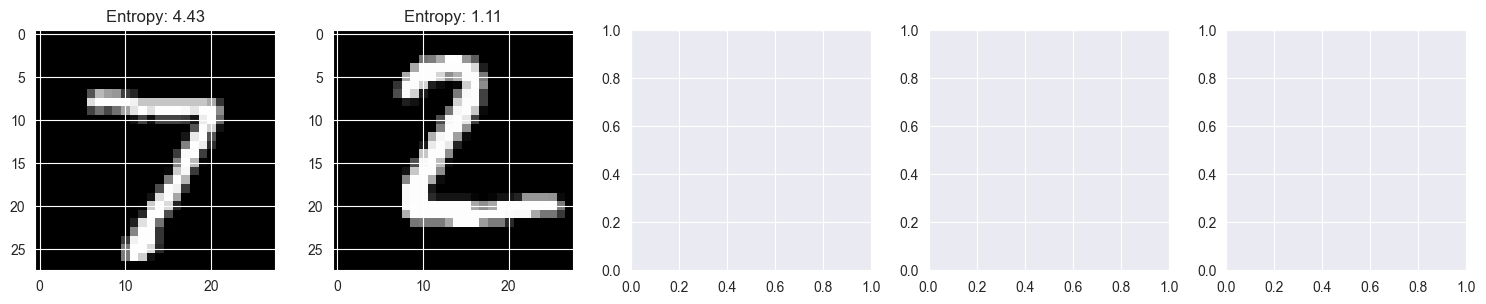

In [33]:
num_images = 5  # or however many you want to display
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # Adjust the size as needed
for idx, ax in zip(high_uncertainty_indexes[:num_images], axes):
    ax.imshow(x_test[idx].squeeze(), cmap='gray')
    ax.set_title(f'Entropy: {mean_uncertainties[idx]:.2f}')
    ax.axis('on')  # Turn on the axis
plt.tight_layout()
plt.show()


## Individual Input Analysis

Shows the detailed analysis of a single input. It retrieves the label with the highest probability from the model's prediction and the associated predictive entropy (uncertainty of the prediction).

1/1 [==============================] - 0s 11ms/step


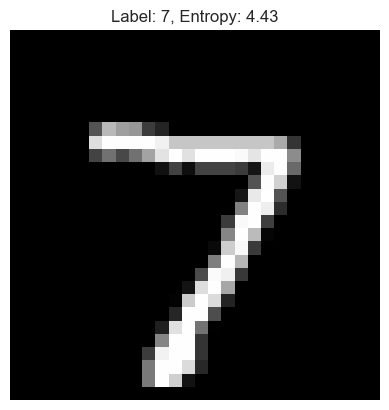

In [138]:
index = high_uncertainty_indexes[0]
predicted_label = np.argmax(model.predict(x_test[index:index+1]), axis=1)[0]

entropy_value = mean_uncertainties[index]

plt.imshow(x_test[index].squeeze(), cmap='gray')
plt.title(f'Label: {predicted_label}, Entropy: {entropy_value:.2f}')
plt.axis('off')
plt.show()

The image og the input is displayed along with the predicted label and its uncertainty value. In this case, the model predicts the label as 7 with a predictive entropy of 4.42, which suggests that the model is relatively uncertain about this prediction. 

1/1 [==============================] - 0s 13ms/step


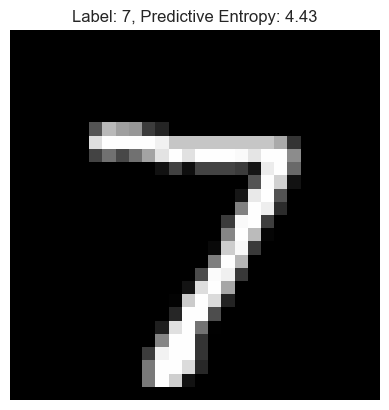

1/1 [==============================] - 0s 10ms/step


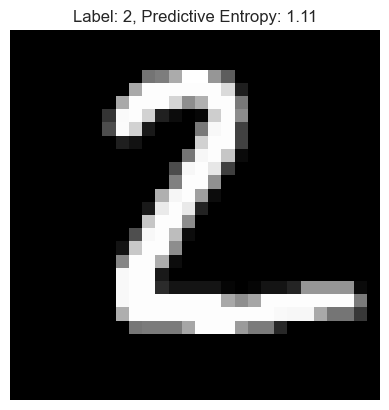

In [35]:
# Display some of the highly uncertain inputs along with their predicted labels
for i in high_uncertainty_indexes[:5]:  # Display the first 5
    plt.figure()
    img = x_test[i].squeeze()
    plt.imshow(img, cmap='gray')
    
    # Predict the label for the current high uncertainty input
    predicted_label = np.argmax(model.predict(x_test[i:i+1]), axis=1)[0]
    
    plt.title(f'Label: {predicted_label}, Predictive Entropy: {mean_uncertainties[i]:.2f}')
    plt.axis('off')
    plt.show()


In [36]:
# Predictive Entropy
clean_uncertainty_entropy = model.predict_quantified(x_test,
                                                     quantifier='predictive_entropy',
                                                     batch_size=64,
                                                     sample_size=32,
                                                     verbose=1)

adv_uncertainty_entropy = model.predict_quantified(x_test_adv,
                                                   quantifier='predictive_entropy',
                                                   batch_size=64,
                                                   sample_size=32,
                                                   verbose=1)

# Mutual Information
clean_uncertainty_mi = model.predict_quantified(x_test,
                                                quantifier='mutual_information',
                                                batch_size=64,
                                                sample_size=32,
                                                verbose=1)

adv_uncertainty_mi = model.predict_quantified(x_test_adv,
                                              quantifier='mutual_information',
                                              batch_size=64,
                                              sample_size=32,
                                              verbose=1)

5000/5000 [==============================] - 18s 4ms/step


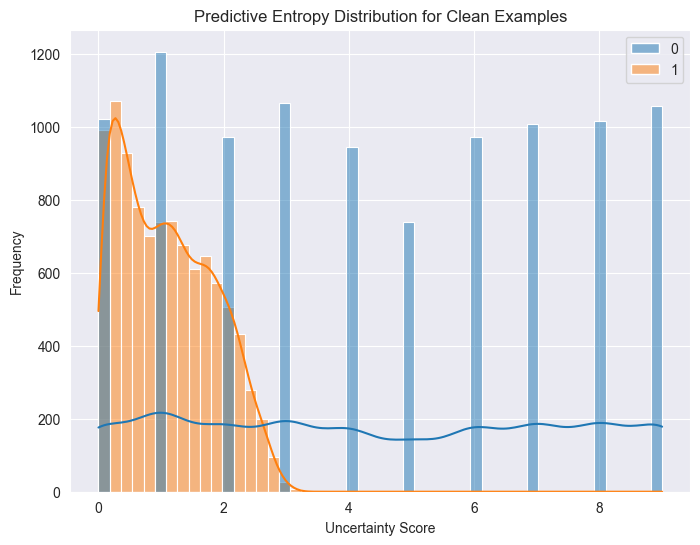

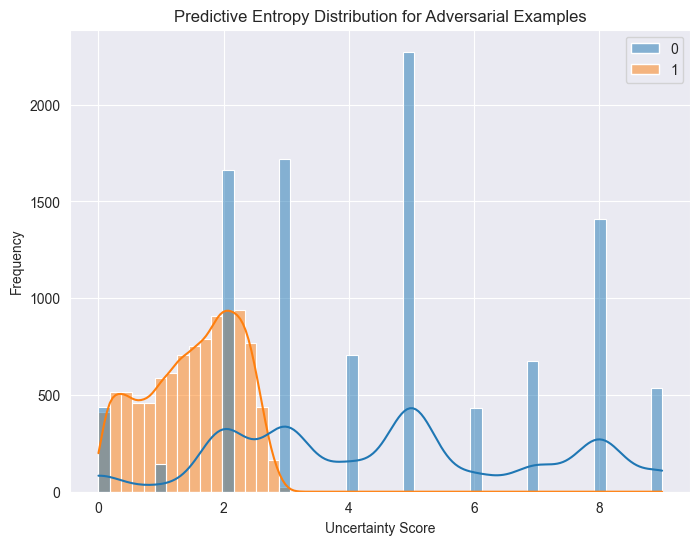

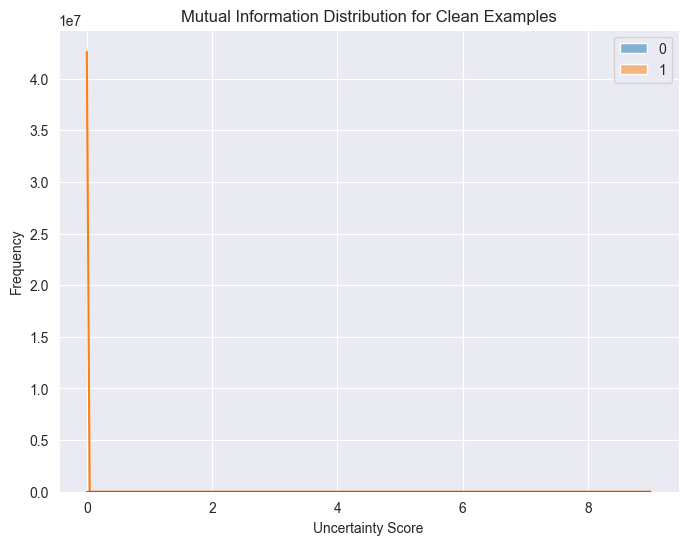

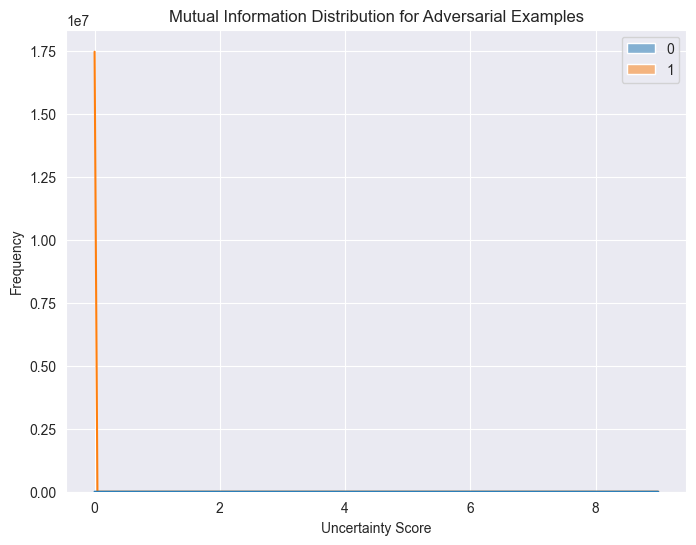

In [37]:
def plot_uncertainty_distribution(uncertainties, title):
    plt.figure(figsize=(8, 6))
    sns.histplot(uncertainties, bins=50, kde=True)
    plt.title(title)
    plt.xlabel('Uncertainty Score')
    plt.ylabel('Frequency')
    plt.show()
    
plot_uncertainty_distribution(clean_uncertainty_entropy, 'Predictive Entropy Distribution for Clean Examples')
plot_uncertainty_distribution(adv_uncertainty_entropy, 'Predictive Entropy Distribution for Adversarial Examples')
plot_uncertainty_distribution(clean_uncertainty_mi, 'Mutual Information Distribution for Clean Examples')
plot_uncertainty_distribution(adv_uncertainty_mi, 'Mutual Information Distribution for Adversarial Examples')

## Histogram of Uncertainty Score

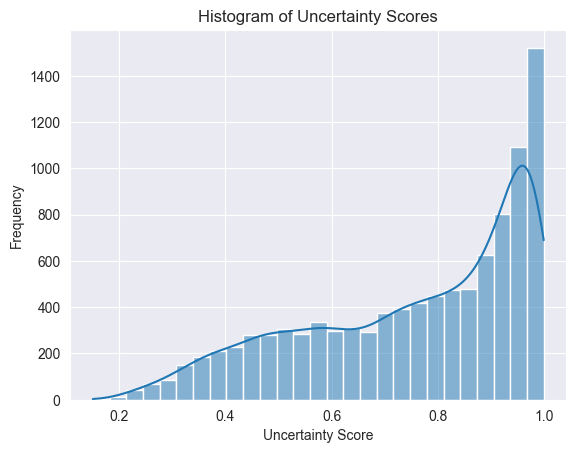

In [38]:
sns.histplot(uncertainty_scores, kde=True)
plt.title('Histogram of Uncertainty Scores')
plt.xlabel('Uncertainty Score')
plt.ylabel('Frequency')
plt.show()

## Scatter Plot of Predictive Confidence vs Uncertainty Score

 We need two arrays: one for predictive confidence (e.g., softmax output of the predicted class) named predictive_confidence and another for uncertainty scores named uncertainty_scores.
 
Predictive confidence is typically the max softmax probability for the predicted class

313/313 [==============================] - 1s 3ms/step


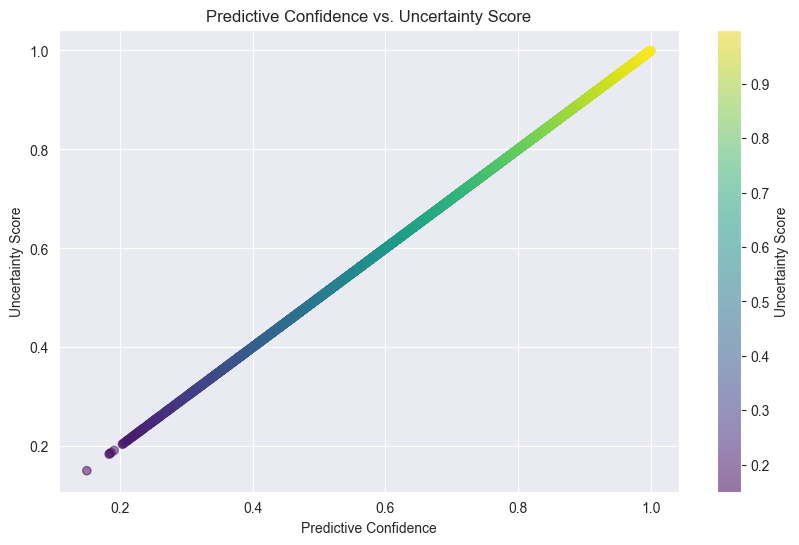

In [39]:
predictive_confidence = np.max(model.predict(x_test), axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(predictive_confidence, uncertainty_scores, c=uncertainty_scores, cmap='viridis', alpha=0.5)
plt.colorbar(label='Uncertainty Score')
plt.title('Predictive Confidence vs. Uncertainty Score')
plt.xlabel('Predictive Confidence')
plt.ylabel('Uncertainty Score')
plt.show()

## Image Grid og Highly Uncertain Inputs

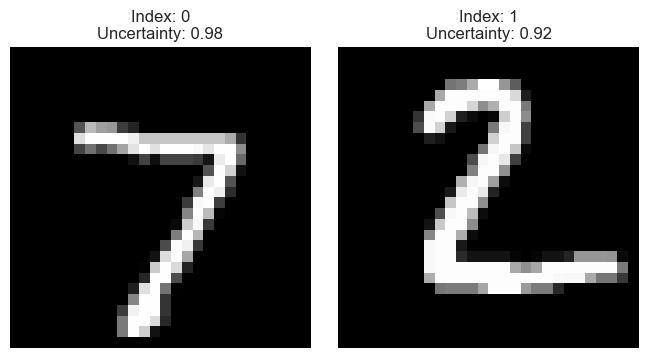

In [40]:
# Display the first N highly uncertain images 
N = 9
plt.figure(figsize=(10, 10))

for i, idx in enumerate(high_uncertainty_indexes[:N]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f'Index: {idx}\nUncertainty: {uncertainty_scores[idx]:.2f}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

1. Run the model with dropout enabled during testing time to get a distribution of predictions for each input.
2. Calculate uncertainty scores from these predictions. Common methods include variance, entropy, or mutual information.
3. Plot the distribution of uncertainty scores for the entire test set.
4. Analyze the relationship between uncertainty scores and prediction errors. 
5. Plotting prediction error against uncertainty score and looking for a score beyond which errors become more common

313/313 [==============================] - 1s 3ms/step


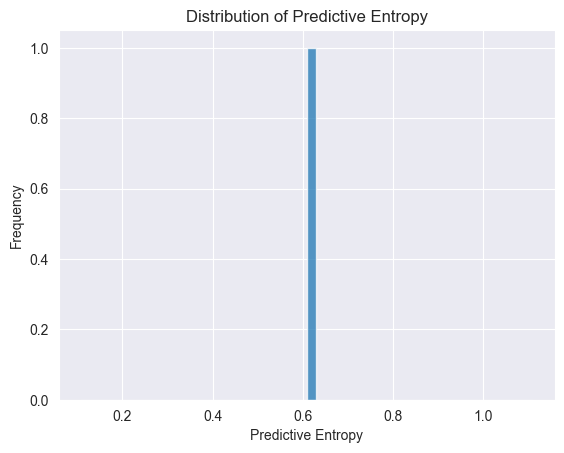

In [41]:
# Step 1: Run the model num_sample times to get a distribution of predictions.
num_samples_uncertainty = 100 # Number of stochastic forward passes
predictions_uncertainty = np.array([model.predict(x_test, verbose=1) for _ in range(num_samples_uncertainty)])

# Step 2: Calculate uncertainty scores from these predictions
# We'll use predictive entropy as our uncertainty measure
predictive_entropy = -np.sum(predictions * np.log(predictions + 1e-6), axis=-1) # Adding a small constant to avoid log(0)
mean_predictive_entropy = np.mean(predictive_entropy, axis=0)

# Step 3: Plot the distribution of uncertainty scores for the entire test set
plt.hist(mean_predictive_entropy, bins=50, alpha=0.75)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy')
plt.show()

## Relationship between uncertainty scores and prediction errors.

### Prediction Error vs. Predictive Entropy

**Prediction Error** is a binary indicator on the y-axis where 0 represents a correct prediction and 1 represents an incorrect prediction by the model.

**Predictive Entropy** on the x-axis represents predictive entropy which is a measure of uncertainty in the predictions. Higher entropy values indicate greater uncertainty

In [42]:
# First, check the shape of y_test to see if it's already one-hot encoded
print(f'y_test shape: {y_test.shape}')

# If y_test is not one-hot encoded (i.e., if it has shape (num_samples, 1) or (num_samples,))
# then you will need to one-hot encode it
if y_test.ndim == 1 or (y_test.ndim == 2 and y_test.shape[1] == 1):
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Now try evaluating the model again
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')



y_test shape: (10000,)
313/313 - 2s - loss: 0.4794 - accuracy: 0.8747 - 2s/epoch - 8ms/step

Test Loss: 0.479, Test Accuracy: 0.875


Each point on the scatter represents an individual prediction by the model. The x-coordinate of a point reflects the uncertainty of the model about that particular prediction (with rightmost points being the most uncertain).
The y-coordinate indicates whether the prediction was correct (0) or incorrect (1)

A well-calibrated model would show higher entropy (uncertainty) primarily for incorrect predictions. Correct predictions (y=0) should ideally have low entropy, meaning the model is certain about its correct predictions.
Incorrect predictions (y=1) with low entropy suggest overconfidence - the model was wrong but thought it was right.
Points clustered at the bottom (y=0) are correct predictions, and their spread along the x-axis indicates the range of certainty the model had for those predictions.
Points at the top (y=1) are the wrong predictions. Ideally these should be fewer and have higher entropy, showing that the model recognizes its uncertainty.

A large cluster of points at y=1 with low entropy would be concerning, as it would indicate the model is frequently confident and wrong. Conversely, a lot of points at y=0 with high entropy would suggest the model is too uncertain about its correct predictions.



Model weights loaded from disk
313/313 - 2s - loss: 0.4794 - accuracy: 0.8747 - 2s/epoch - 8ms/step

Test Loss: 0.479, Test Accuracy: 0.875
313/313 [==============================] - 1s 3ms/step

MSE: 0.021
y_pred_classes shape: (10000,)
y_true shape: (10000,)
157/157 [==============================] - 1s 3ms/step
Length of uncertainty_scores: 10000


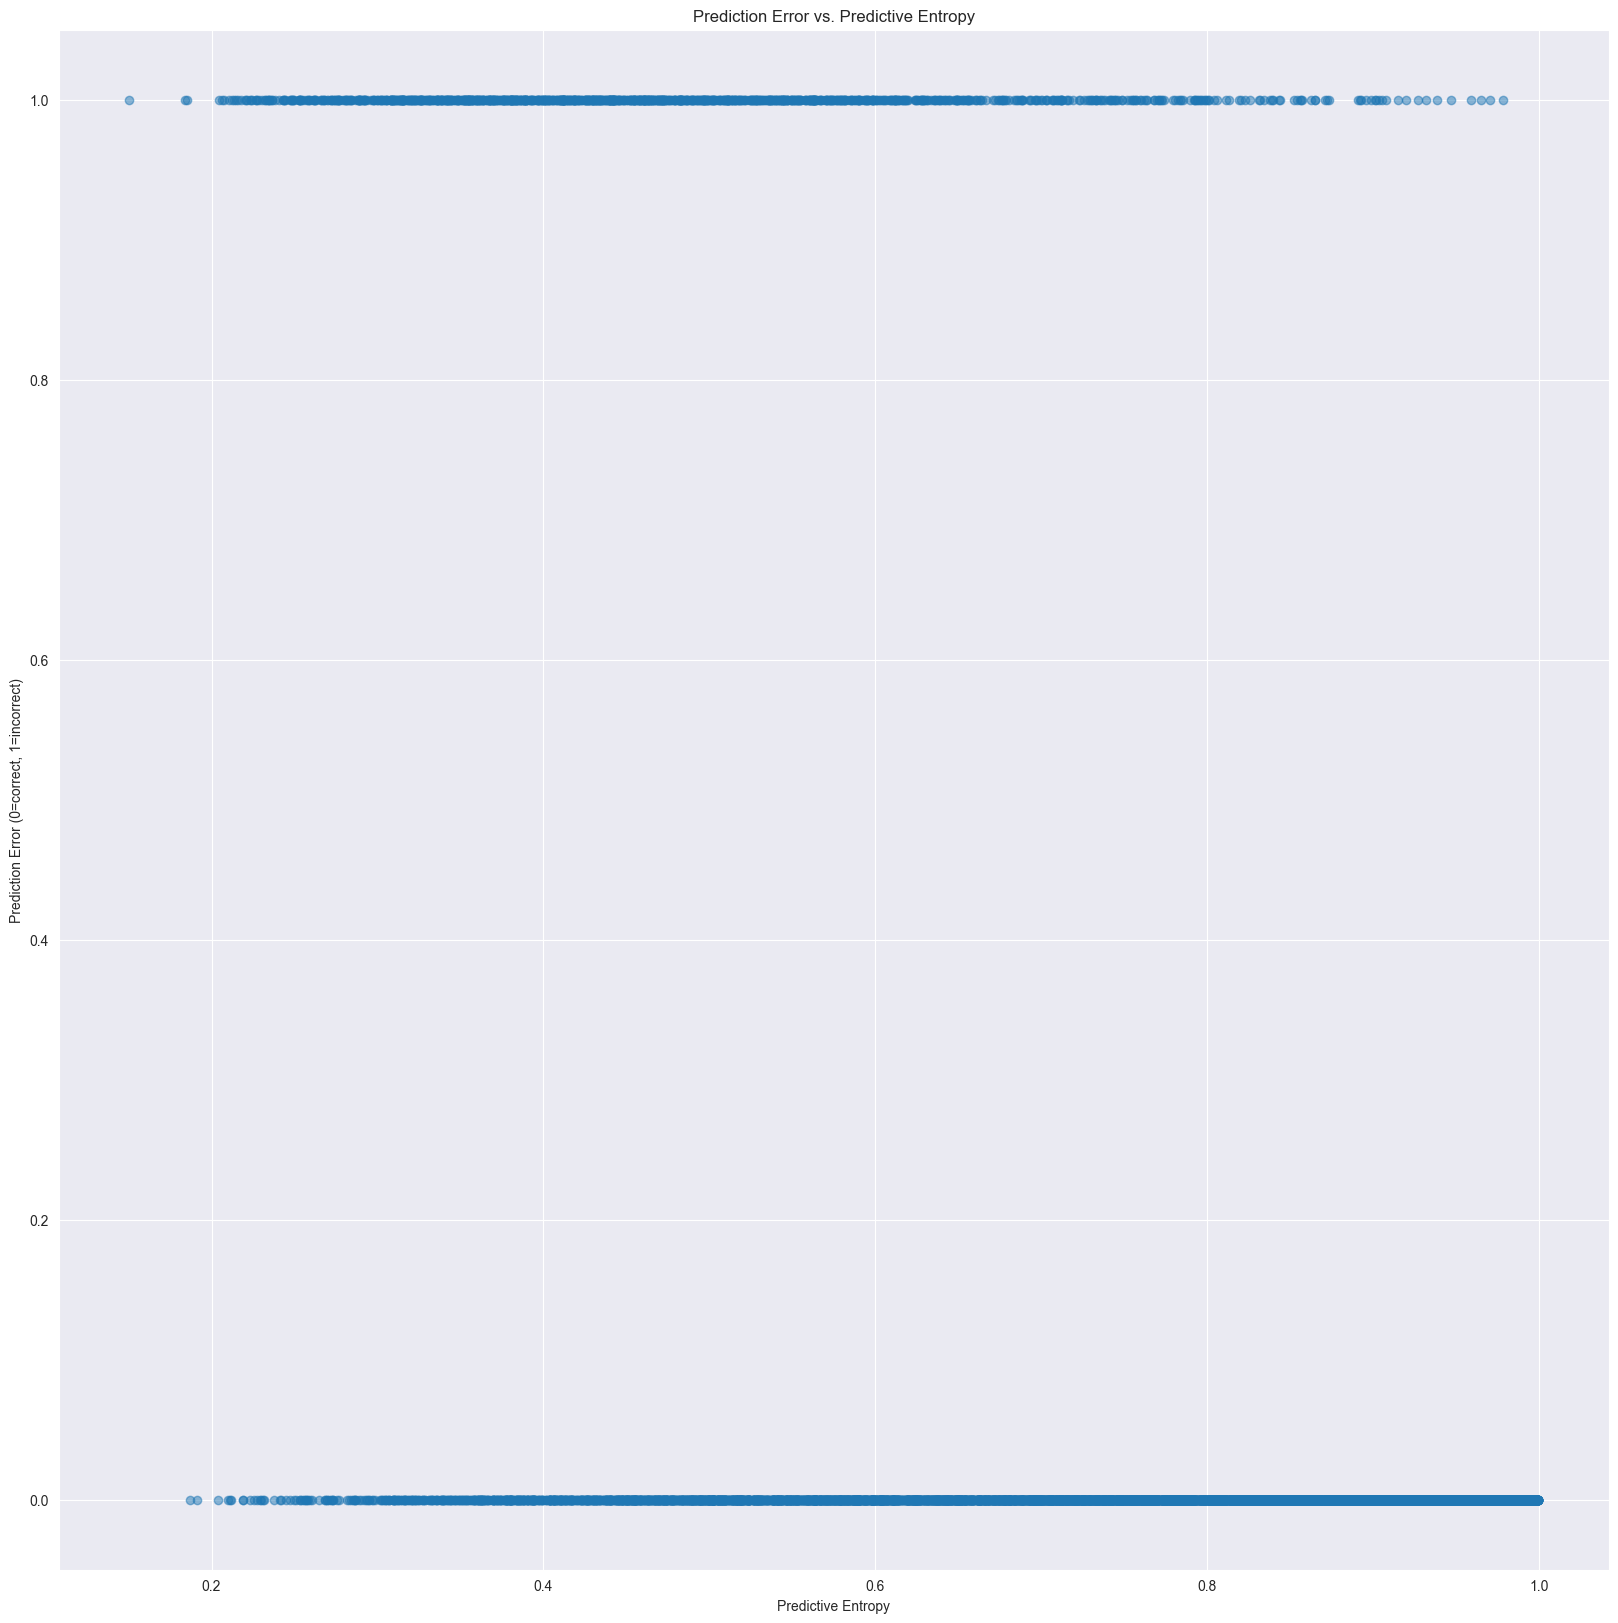

In [43]:
# Load the saved model weights
model.inner.load_weights('data/model/clean_model_weights.h5')
print("Model weights loaded from disk")

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

# Making predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the mean squared error
mse = tf.reduce_mean(tf.square(y_pred - y_test))
print(f'\nMSE: {mse:.3f}')

# Confirm the shapes of y_pred_classes and y_true
print(f'y_pred_classes shape: {y_pred_classes.shape}')
print(f'y_true shape: {y_true.shape}')

# Perform uncertainty quantification
quantifiers = ['pcs', 'mean_softmax']
results = model.predict_quantified(x_test, quantifier=quantifiers, batch_size=64, sample_size=32, verbose=1)

# Obtain the uncertainty scores
uncertainty_scores = results[1][1]  # Assuming this is the correct index for entropy

# Verify the length of uncertainty_scores matches the number of predictions
print(f'Length of uncertainty_scores: {len(uncertainty_scores)}')

# Now, calculate prediction errors correctly
prediction_errors = (y_pred_classes != y_true).astype(int)  # 1 for error, 0 for correct

# Ensure lengths match before plotting
if len(uncertainty_scores) == len(prediction_errors):
    plt.figure(figsize=(20,20))
    plt.scatter(uncertainty_scores, prediction_errors, alpha=0.5)
    plt.xlabel('Predictive Entropy')
    plt.ylabel('Prediction Error (0=correct, 1=incorrect)')
    plt.title('Prediction Error vs. Predictive Entropy')
    plt.show()
else:
    print('Mismatch in lengths of uncertainty scores and prediction errors')
